## Setup

In [20]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers

# Configuration parameters for the whole setup
seed = 42
gamma = 0.99  # Discount factor for past rewards
max_steps_per_episode = 10000
env = gym.make("CartPole-v1")  # Create the environment
env.seed(seed)
eps = np.finfo(np.float32).eps.item()  # Smallest number such that 1.0 + eps != 1.0

  deprecation(

  deprecation(

  deprecation(



## Environment

In [ ]:
# Run a demo of the environment
observation = env.reset()
cum_reward = 0
cart_frames = []
for t in range(5000):
    # Render into buffer. 
    cart_frames.append(env.render(mode='rgb_array'))
    action = env.action_space.sample()
    observation, reward, done, _ = env.step(action)
    if done:
        break

## Display

In [ ]:
from matplotlib import animation, rc
rc('animation', html='jshtml')
fig, ax = plt.subplots(figsize = (5, 3))
im = ax.imshow(cart_frames[0])
def updatefig(frame):
    im.set_array(cart_frames[frame])
    return im,
anim = animation.FuncAnimation(fig, updatefig, 
                             frames = range(1, len(cart_frames)), interval=120, blit=True)
anim

## Network

In [12]:
num_inputs = 4
num_actions = 2
num_hidden = 128

inputs = layers.Input(shape=(num_inputs,))
common = layers.Dense(num_hidden, activation="relu")(inputs)
action = layers.Dense(num_actions, activation="softmax")(common)
critic = layers.Dense(1)(common)

model = keras.Model(inputs=inputs, outputs=[action, critic])

## Training

In [13]:
optimizer = keras.optimizers.Adam(learning_rate=0.01)
huber_loss = keras.losses.Huber()
action_probs_history = []
critic_value_history = []
rewards_history = []
running_reward = 0
episode_count = 0

while True:  # Run until solved
    state = env.reset()
    episode_reward = 0
    with tf.GradientTape() as tape:
        for timestep in range(1, max_steps_per_episode):
            # env.render(); Adding this line would show the attempts
            # of the agent in a pop up window.

            state = tf.convert_to_tensor(state)
            state = tf.expand_dims(state, 0)

            # Predict action probabilities and estimated future rewards
            # from environment state
            action_probs, critic_value = model(state)
            critic_value_history.append(critic_value[0, 0])

            # Sample action from action probability distribution
            action = np.random.choice(num_actions, p=np.squeeze(action_probs))
            action_probs_history.append(tf.math.log(action_probs[0, action]))

            # Apply the sampled action in our environment
            state, reward, done, _ = env.step(action)
            rewards_history.append(reward)
            episode_reward += reward

            if done:
                break

        # Update running reward to check condition for solving
        running_reward = 0.05 * episode_reward + (1 - 0.05) * running_reward

        # Calculate expected value from rewards
        # - At each timestep what was the total reward received after that timestep
        # - Rewards in the past are discounted by multiplying them with gamma
        # - These are the labels for our critic
        returns = []
        discounted_sum = 0
        for r in rewards_history[::-1]:
            discounted_sum = r + gamma * discounted_sum
            returns.insert(0, discounted_sum)

        # Normalize
        returns = np.array(returns)
        returns = (returns - np.mean(returns)) / (np.std(returns) + eps)
        returns = returns.tolist()

        # Calculating loss values to update our network
        history = zip(action_probs_history, critic_value_history, returns)
        actor_losses = []
        critic_losses = []
        for log_prob, value, ret in history:
            # At this point in history, the critic estimated that we would get a
            # total reward = `value` in the future. We took an action with log probability
            # of `log_prob` and ended up recieving a total reward = `ret`.
            # The actor must be updated so that it predicts an action that leads to
            # high rewards (compared to critic's estimate) with high probability.
            diff = ret - value
            actor_losses.append(-log_prob * diff)  # actor loss

            # The critic must be updated so that it predicts a better estimate of
            # the future rewards.
            critic_losses.append(
                huber_loss(tf.expand_dims(value, 0), tf.expand_dims(ret, 0))
            )

        # Backpropagation
        loss_value = sum(actor_losses) + sum(critic_losses)
        grads = tape.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # Clear the loss and reward history
        action_probs_history.clear()
        critic_value_history.clear()
        rewards_history.clear()

    # Log details
    episode_count += 1
    if episode_count % 10 == 0:
        template = "running reward: {:.2f} at episode {}"
        print(template.format(running_reward, episode_count))

    if running_reward > 195:  # Condition to consider the task solved
        template = "Solved at episode {} with reward {:.2f}!"
        print(template.format(episode_count, running_reward))
        break

running reward: 6.64 at episode 10
running reward: 10.12 at episode 20
running reward: 13.60 at episode 30
running reward: 14.58 at episode 40
running reward: 14.53 at episode 50
running reward: 14.54 at episode 60
running reward: 16.72 at episode 70
running reward: 22.47 at episode 80
running reward: 33.45 at episode 90
running reward: 33.13 at episode 100
running reward: 38.90 at episode 110
running reward: 47.48 at episode 120
running reward: 46.83 at episode 130
running reward: 59.49 at episode 140
running reward: 74.77 at episode 150
running reward: 90.36 at episode 160
running reward: 87.22 at episode 170
running reward: 92.37 at episode 180
running reward: 112.59 at episode 190
running reward: 176.98 at episode 200
running reward: 164.56 at episode 210
running reward: 151.78 at episode 220
running reward: 137.75 at episode 230
running reward: 157.02 at episode 240
running reward: 162.77 at episode 250
running reward: 141.35 at episode 260
running reward: 156.49 at episode 270
ru

## Inference

In [18]:
cart_frames2 = []
episode_count = 0
while True:  # Run until solved
    state = env.reset()
    episode_reward = 0
    with tf.GradientTape() as tape:
        for timestep in range(1, max_steps_per_episode):
            # env.render(); Adding this line would show the attempts
            # of the agent in a pop up window.
            state = tf.convert_to_tensor(state)
            state = tf.expand_dims(state, 0)

            # Predict action probabilities and estimated future rewards
            # from environment state
            action_probs, critic_value = model(state)

            # Sample action from action probability distribution
            action = np.random.choice(num_actions, p=np.squeeze(action_probs))

            # Apply the sampled action in our environment
            cart_frames2.append(env.render(mode='rgb_array'))
            state, reward, done, _ = env.step(action)
            episode_reward += reward

            if done:
                break

        # Update running reward to check condition for solving
        running_reward = 0.05 * episode_reward + (1 - 0.05) * running_reward


    if running_reward > 190:  # Condition to consider the task solved
        template = "Episode {} with reward {:.2f}!"
        print(template.format(episode_count, running_reward))
        break

Episode 0 with reward 212.68!


## Display

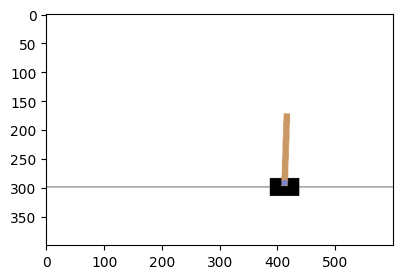

In [19]:
from matplotlib import animation, rc
rc('animation', html='jshtml')
fig, ax = plt.subplots(figsize = (5, 3))
im = ax.imshow(cart_frames2[0])
def updatefig(frame):
    im.set_array(cart_frames2[frame])
    return im,
anim = animation.FuncAnimation(fig, updatefig, 
                             frames = range(1, len(cart_frames2)), interval=120, blit=True)
anim